In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("./train.csv")
data.head()

,Label,times,F0(pitch),F1,F2,F3,F4,F5
0,BYJ,0.037993,NaN,934.456137,1867.766912,2958.658056,4026.961381,NaN
1,BYJ,0.137993,NaN,1338.936874,2694.203872,2875.547156,4229.574451,NaN
2,BYJ,0.237993,NaN,1160.135803,2144.572867,3476.990084,4433.055683,NaN
3,BYJ,0.337993,NaN,211.203260,1472.209366,2708.645128,3839.022388,NaN
4,BYJ,0.437993,NaN,381.149933,1721.053643,2682.587186,3957.900682,NaN


In [3]:
print("라벨:", data["Label"].unique(), sep="\n")

라벨:
['BYJ' 'HYN' 'SJW']


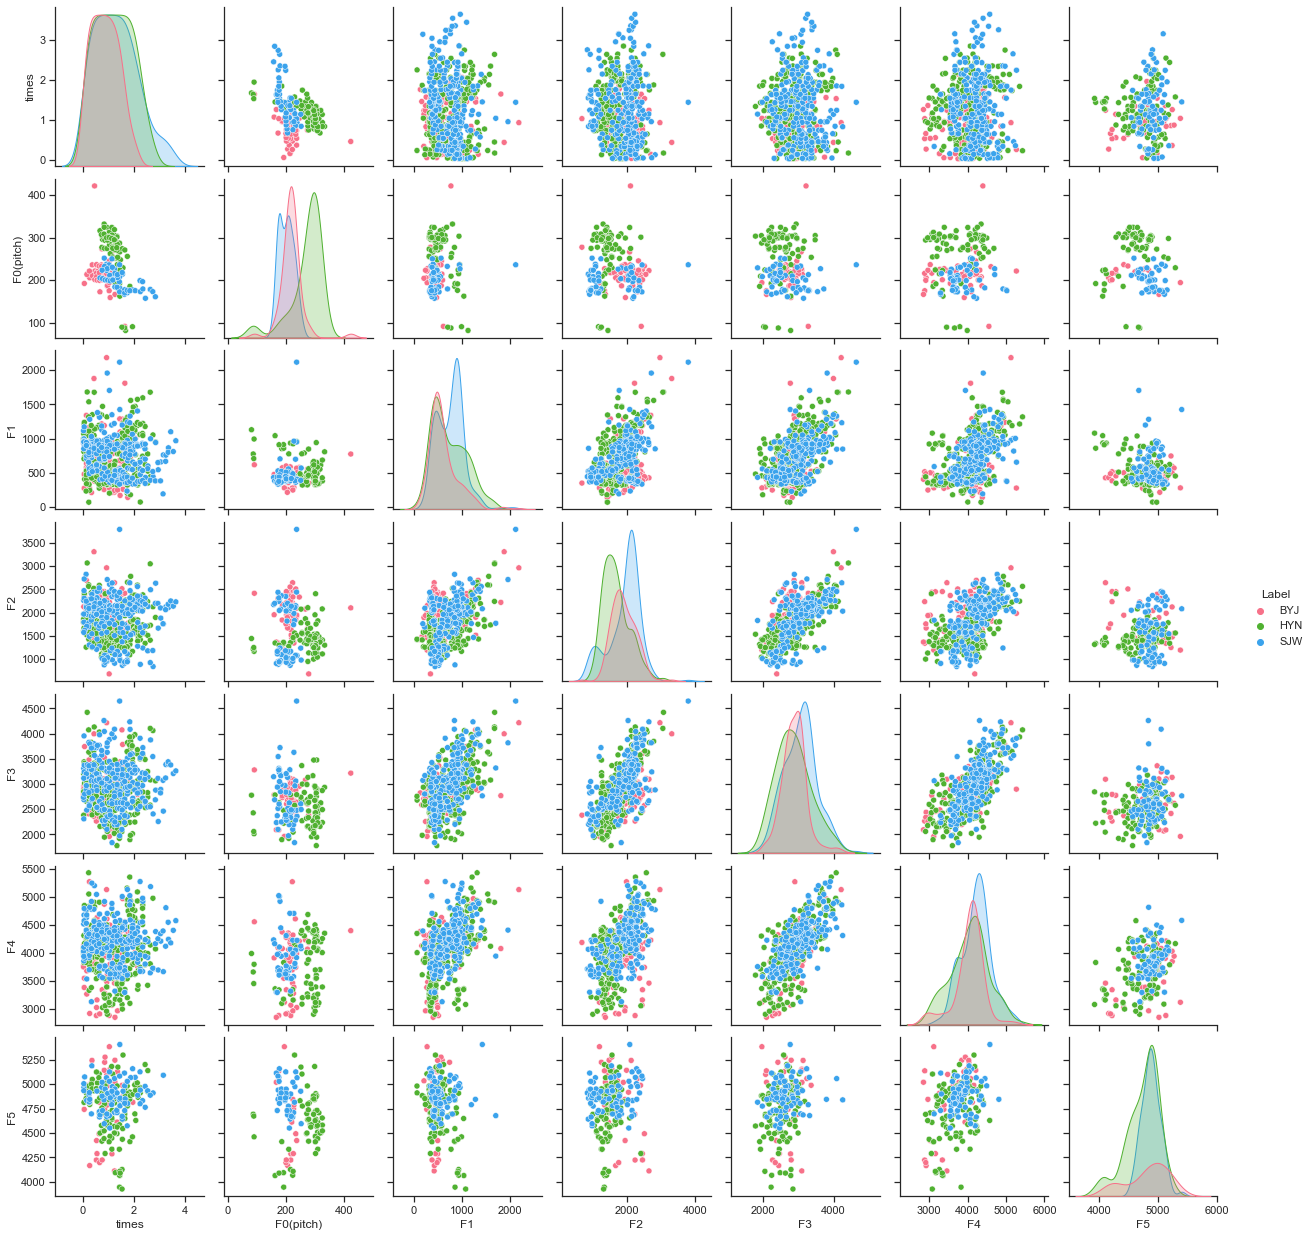

In [4]:
#3명이 7개의 피쳐에 대해 어떤 분포를 가지고 있는지 시각화
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data, hue="Label", palette="husl")

### preprocess

In [5]:
import tensorflow as tf
import os
import datetime
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [6]:
train_data = data.fillna(value=0)
user_id_arr = train_data['Label'].unique()
user_count = user_id_arr.shape[0]
train_data = pd.get_dummies(train_data)
train_data = train_data.astype('float64')
train_data = shuffle(train_data)
X_len=len(train_data.columns)-user_count
y_len=user_count
X=train_data.iloc[:,0:X_len]
y=train_data.iloc[:,-user_count:]

In [7]:
X.head()

,times,F0(pitch),F1,F2,F3,F4,F5
96,0.857993,0.000000,432.022357,1607.184748,3022.977141,4263.493178,0.000000
412,0.346000,0.000000,966.673527,2277.035270,3775.464105,4779.703065,0.000000
184,1.570000,229.194521,452.747688,1560.264300,2578.165341,4168.351117,5299.625378
447,0.441333,0.000000,972.495772,2040.612557,3224.898026,4428.712973,0.000000
251,1.044660,283.281118,507.958393,1662.712895,2748.943639,4006.660868,4588.428741


In [8]:
y.head()

,Label_BYJ,Label_HYN,Label_SJW
96,1.0,0.0,0.0
412,0.0,0.0,1.0
184,0.0,1.0,0.0
447,0.0,0.0,1.0
251,0.0,1.0,0.0


### train

In [9]:
#ready model

k=20 #fold
num_val_samples=len(X)//20

sc = StandardScaler()
classifier = Sequential()

unit = 15
rate = 0.3

# 1st layer(input)
classifier.add(Dense(units = unit, kernel_initializer = 'glorot_uniform', activation = 'relu', input_dim = X_len))

# 2nd layer
classifier.add(Dense(units = unit, kernel_initializer = 'glorot_uniform', activation = 'relu'))
classifier.add(Dropout(rate))

# 3rd layer
classifier.add(Dense(units = unit, kernel_initializer = 'glorot_uniform', activation = 'relu'))
classifier.add(Dropout(rate))

# 4th layer
classifier.add(Dense(units = unit, kernel_initializer = 'glorot_uniform', activation = 'relu'))
classifier.add(Dropout(rate))

# 5th layer(output)
classifier.add(Dense(units = user_count, kernel_initializer = 'glorot_uniform', activation = 'softmax'))

# compile
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0

In [10]:
#fitting and validation through cross validation

for i in range(k):
    print('fold num #',i+1)
    
    #validation data
    val_data=X[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=y[i*num_val_samples:(i+1)*num_val_samples]
    
    #ready train data and target data
    partial_train_data=np.concatenate([X[:i*num_val_samples], X[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets=np.concatenate([y[:i*num_val_samples], y[(i+1)*num_val_samples:]],axis=0)
    
    #Feature Scaling
    partial_train_data=sc.fit_transform(partial_train_data)
    val_data=sc.transform(val_data)
    
    #fitting
    classifier.fit(partial_train_data, partial_train_targets, batch_size = 40, epochs = 40)

fold num # 1
Epoch 1/40
16/16 [==============================] - 0s 1ms/step - loss: 1.1783 - accuracy: 0.3413
Epoch 2/40
16/16 [==============================] - 0s 1ms/step - loss: 1.1279 - accuracy: 0.3381
Epoch 3/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0964 - accuracy: 0.3830
Epoch 4/40
16/16 [==============================] - 0s 1ms/step - loss: 1.1009 - accuracy: 0.3830
Epoch 5/40
16/16 [==============================] - 0s 536us/step - loss: 1.0818 - accuracy: 0.3926
Epoch 6/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0867 - accuracy: 0.4054
Epoch 7/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0802 - accuracy: 0.3910
Epoch 8/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0729 - accuracy: 0.4038
Epoch 9/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0513 - accuracy: 0.4391
Epoch 10/40
16/16 [==============================] - 0s 1ms/step - loss: 1.0597 - accuracy: 0.4183
Epoc

16/16 [==============================] - 0s 615us/step - loss: 0.8387 - accuracy: 0.5962
Epoch 4/40
16/16 [==============================] - 0s 588us/step - loss: 0.8562 - accuracy: 0.6122
Epoch 5/40
16/16 [==============================] - 0s 560us/step - loss: 0.8426 - accuracy: 0.6170
Epoch 6/40
16/16 [==============================] - 0s 1ms/step - loss: 0.8612 - accuracy: 0.5978
Epoch 7/40
16/16 [==============================] - 0s 1ms/step - loss: 0.8312 - accuracy: 0.6106
Epoch 8/40
16/16 [==============================] - 0s 573us/step - loss: 0.8639 - accuracy: 0.6122
Epoch 9/40
16/16 [==============================] - 0s 563us/step - loss: 0.8528 - accuracy: 0.6186
Epoch 10/40
16/16 [==============================] - 0s 535us/step - loss: 0.8497 - accuracy: 0.6090
Epoch 11/40
16/16 [==============================] - 0s 559us/step - loss: 0.8633 - accuracy: 0.5897
Epoch 12/40
16/16 [==============================] - 0s 565us/step - loss: 0.8263 - accuracy: 0.6314
Epoch 13/40


16/16 [==============================] - 0s 1ms/step - loss: 0.7504 - accuracy: 0.6987
Epoch 5/40
16/16 [==============================] - 0s 1ms/step - loss: 0.7291 - accuracy: 0.7003
Epoch 6/40
16/16 [==============================] - 0s 1ms/step - loss: 0.7094 - accuracy: 0.7035
Epoch 7/40
16/16 [==============================] - 0s 1ms/step - loss: 0.7063 - accuracy: 0.7051
Epoch 8/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.7067
Epoch 9/40
16/16 [==============================] - 0s 533us/step - loss: 0.7117 - accuracy: 0.7019
Epoch 10/40
16/16 [==============================] - 0s 534us/step - loss: 0.7389 - accuracy: 0.6859
Epoch 11/40
16/16 [==============================] - 0s 1ms/step - loss: 0.7337 - accuracy: 0.6907
Epoch 12/40
16/16 [==============================] - 0s 535us/step - loss: 0.7082 - accuracy: 0.6843
Epoch 13/40
16/16 [==============================] - 0s 532us/step - loss: 0.7003 - accuracy: 0.6955
Epoch 14/40
16/16 [

16/16 [==============================] - 0s 1ms/step - loss: 0.6288 - accuracy: 0.7548
Epoch 6/40
16/16 [==============================] - 0s 534us/step - loss: 0.6271 - accuracy: 0.7468
Epoch 7/40
16/16 [==============================] - 0s 536us/step - loss: 0.6426 - accuracy: 0.7083
Epoch 8/40
16/16 [==============================] - 0s 992us/step - loss: 0.6181 - accuracy: 0.7628
Epoch 9/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6272 - accuracy: 0.7388
Epoch 10/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6415 - accuracy: 0.7436
Epoch 11/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6091 - accuracy: 0.7452
Epoch 12/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6026 - accuracy: 0.7484
Epoch 13/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6129 - accuracy: 0.7452
Epoch 14/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6347 - accuracy: 0.7404
Epoch 15/40
16/16 [=

Epoch 7/40
16/16 [==============================] - 0s 828us/step - loss: 0.6165 - accuracy: 0.7468
Epoch 8/40
16/16 [==============================] - 0s 943us/step - loss: 0.6062 - accuracy: 0.7724
Epoch 9/40
16/16 [==============================] - 0s 816us/step - loss: 0.6020 - accuracy: 0.7580
Epoch 10/40
16/16 [==============================] - 0s 800us/step - loss: 0.6062 - accuracy: 0.7596
Epoch 11/40
16/16 [==============================] - 0s 647us/step - loss: 0.6152 - accuracy: 0.7580
Epoch 12/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5900 - accuracy: 0.7788
Epoch 13/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6506 - accuracy: 0.7260
Epoch 14/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.7436
Epoch 15/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7612
Epoch 16/40
16/16 [==============================] - 0s 1ms/step - loss: 0.6293 - accuracy: 0.7500
Epo

16/16 [==============================] - 0s 1ms/step - loss: 0.5922 - accuracy: 0.7596
Epoch 10/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7564
Epoch 11/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5846 - accuracy: 0.7772
Epoch 12/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5706 - accuracy: 0.7596
Epoch 13/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7548
Epoch 14/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.7564
Epoch 15/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5869 - accuracy: 0.7740
Epoch 16/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.7612
Epoch 17/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5860 - accuracy: 0.7484
Epoch 18/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5897 - accuracy: 0.7596
Epoch 19/40
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.5627 - accuracy: 0.7869
Epoch 11/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5479 - accuracy: 0.7821
Epoch 12/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.7516
Epoch 13/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5692 - accuracy: 0.7869
Epoch 14/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5296 - accuracy: 0.7853
Epoch 15/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7804
Epoch 16/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.7853
Epoch 17/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5667 - accuracy: 0.7484
Epoch 18/40
16/16 [==============================] - 0s 851us/step - loss: 0.5412 - accuracy: 0.7853
Epoch 19/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5732 - accuracy: 0.7853
Epoch 20/40
16/16 [=

16/16 [==============================] - 0s 1ms/step - loss: 0.5183 - accuracy: 0.7772
Epoch 13/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5471 - accuracy: 0.7740
Epoch 14/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.7804
Epoch 15/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5288 - accuracy: 0.7885
Epoch 16/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.7692
Epoch 17/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5376 - accuracy: 0.7772
Epoch 18/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5566 - accuracy: 0.7772
Epoch 19/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5630 - accuracy: 0.7853
Epoch 20/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5357 - accuracy: 0.7804
Epoch 21/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.7724
Epoch 22/40
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.7885
Epoch 15/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5164 - accuracy: 0.8013
Epoch 16/40
16/16 [==============================] - 0s 888us/step - loss: 0.4864 - accuracy: 0.8077
Epoch 17/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5116 - accuracy: 0.7901
Epoch 18/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5235 - accuracy: 0.7644
Epoch 19/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5292 - accuracy: 0.7837
Epoch 20/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5237 - accuracy: 0.7853
Epoch 21/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5170 - accuracy: 0.7901
Epoch 22/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5453 - accuracy: 0.7853
Epoch 23/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5193 - accuracy: 0.7580
Epoch 24/40
16/16 [=

16/16 [==============================] - 0s 1ms/step - loss: 0.5043 - accuracy: 0.8109
Epoch 16/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5226 - accuracy: 0.7853
Epoch 17/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5064 - accuracy: 0.8157
Epoch 18/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5348 - accuracy: 0.7853
Epoch 19/40
16/16 [==============================] - 0s 875us/step - loss: 0.5009 - accuracy: 0.8093
Epoch 20/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5316 - accuracy: 0.7708
Epoch 21/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5069 - accuracy: 0.7821
Epoch 22/40
16/16 [==============================] - 0s 1ms/step - loss: 0.5192 - accuracy: 0.8093
Epoch 23/40
16/16 [==============================] - 0s 534us/step - loss: 0.5079 - accuracy: 0.7949
Epoch 24/40
16/16 [==============================] - 0s 533us/step - loss: 0.5042 - accuracy: 0.7933
Epoch 25/40
16/1

### test ###

In [ ]:
test_data = pd.read_csv(file_path)
user_id_arr = test_data['Label'].unique()
user_count = user_id_arr.shape[0]
test_data = pd.get_dummies(test_data)   #one-hot encoding
test_data = test_data.astype('float64')
test_data = shuffle(test_data)

In [ ]:
X_len=len(test_data.columns)-user_count
y_len=user_count
X=test_data.iloc[:,0:X_len]
y=test_data.iloc[:,-user_count:]
test_data.head()

In [ ]:
test_pred=classifier.predict(X)
test_pred=test_pred.tolist()
num = len(test_pred[0])
test_pred_df = pd.DataFrame(test_pred,columns=['Label_BYJ', 'Label_HYN', 'Label_SJW'])
test_pred_df.head()

In [ ]:
batch_size=100
evaluation = classifier.evaluate(X, y, batch_size=batch_size)
evaluation[1]